In [7]:
import re
import os
import time
import sqlite3
import warnings
import itertools
import numpy as np
import pandas as pd 
from tqdm import tqdm
from zipfile import ZipFile

from scipy import spatial
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

from scipy.stats import pearsonr
import matplotlib as mpl
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [8]:
# paper here    https://www.rug.nl/research/portal/files/74389682/paper40.pdf
# download here https://drive.google.com/drive/folders/133EPm4mO9dN6A0Cw6A6Sx1ABa-25BI8e
embedding_ita1_file = './embeddings/model_hate_300.bin' 
# paper here    http://ceur-ws.org/Vol-2263/paper013.pdf
# download here http://www.italianlp.it/resources/italian-word-embeddings/
embedding_ita2_file = './embeddings/itwac128.sqlite' 
# paper here    http://ceur-ws.org/Vol-1404/paper_11.pdf
# download here http://hlt.isti.cnr.it/wordembeddings/
embedding_ita3_file = './embeddings/wiki_w2v/wiki_iter=5_algorithm=skipgram_window=10_size=300_neg-samples=10.m'
# paper here    https://arxiv.org/pdf/1301.3781.pdf
# download here https://code.google.com/archive/p/word2vec/
embedding_eng1_file = './embeddings/GoogleNews-vectors-negative300.bin.gz'
# paper here    https://nlp.stanford.edu/pubs/glove.pdf
# download here https://nlp.stanford.edu/projects/glove/
embedding_eng2_file = './embeddings/glove.6B.300d.txt'

jobs_USA = './support_files/WEFAT_USA.csv'
jobs_ITA = './support_files/WEFAT_ITA.csv'

## Functions to get files and embeddings

In [9]:
def get_embedding(embedding_file): 
    embeds = KeyedVectors.load(embedding_file).wv
    return embeds

def get_embedding2(embedding_file): 
    return Word2Vec.load(embedding_file).wv

def load_wordvec_model(modelFile, flagBin):
    model = KeyedVectors.load_word2vec_format(os.path.join(modelFile), binary=flagBin).wv
    return model

def get_embedding_sqlite(input_file):
    embedding = dict()
    #outfile = codecs.open(sys.argv[2], 'w', 'utf-8')
    with  sqlite3.connect(input_file) as conn:
        c = conn.cursor()
        for row in c.execute("SELECT * from store"):
            if row[0] == "\\t":
                continue
            embedding[row[0]] = row[1:-1]
    return embedding

def load_glove_embeddings(filename):
    with open(embedding_eng2_file, 'r') as f_embed:
        vocab = [line.split()[0] for line in f_embed]
    with open(embedding_eng2_file, 'r') as f_embed:
        vec = [ [float(elem) for elem in line.split()[1:]] for line in f_embed]
    embedding = {w: v for w, v in zip(vocab, vec)}
    return embedding

## Auxiliary functions for experiments by Caliskan et al.

In [22]:
def cosine_similarity(word1, word2, embedding):
    vecs = []
    for term in [word1, word2]:
        try:
            vecs.append(embedding[term])
        except:
            print(term)
            return 0 
    result = 1 - spatial.distance.cosine(vecs[0], vecs[1])
    if result is 'nan':
        result = 0
    return result


def WEAT_word_test(word, A_group, B_group, embedding, word_already_compute={}):
    
    if word in word_already_compute:
        return word_already_compute[word], word_already_compute
    
    mean_a = [cosine_similarity(word, a, embedding) for a in A_group]
    mean_b = [cosine_similarity(word, b, embedding) for b in B_group]
    
    word_already_compute[word] = np.mean(mean_a) - np.mean(mean_b)

    return word_already_compute[word], word_already_compute


def WEAT_group_test(X_names, Y_names, A_group, B_group, embedding, word_already_compute):
    total = 0
    for x in X_names:
        s_word, word_already_compute = WEAT_word_test(x, A_group, B_group, embedding, word_already_compute)
        total += s_word
    for y in Y_names:
        s_word, word_already_compute = WEAT_word_test(y, A_group, B_group, embedding, word_already_compute)
        total -= s_word 
    
    return total, word_already_compute
        

def get_effect_size(X_name, Y_name, word_already_compute):
    X_name_s = [word_already_compute[word] for word in X_name]
    Y_name_s = [word_already_compute[word] for word in Y_name]
    
    effect_size = (np.mean(X_name_s) - np.mean(Y_name_s))/np.std(X_name_s+Y_name_s)
    return effect_size


def get_p_value(X_word, Y_word, A_group, B_group, embedding, s_orig, word_already_compute):
    
    assert(len(X_word) == len(Y_word))
    
    union = set(X_word+Y_word)
    subset_size = int(len(X_word))

    larger = 0
    total = 0
    for subset in set(itertools.combinations(union, subset_size)):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        s_perm, _ = WEAT_group_test(Xi, Yi, A_group, B_group, embedding, word_already_compute)
        if s_perm > s_orig:
            larger += 1
    return larger, total


def gender_WEAT_test(X_words, Y_words, A_group, B_group, embedding):
    word_already_computed = {}
    s_orig, word_already_computed = WEAT_group_test(
        X_words, Y_words, A_group, B_group, embedding, word_already_computed)
    print('WEAT statistic test: {}\n'.format(s_orig))
    
    eff_size = get_effect_size(X_words, Y_words, word_already_computed)
    print('Effective size: {}\n'.format(eff_size))
    
    larger, total = get_p_value(
        male_name, female_name, A_group, B_group, embedding, s_orig, word_already_computed)
    print('Tested {} and {} larger than WEAT statistic test.'.format(total, larger))
    print('p_value: {}'.format(float(larger/total)))

In [11]:
def gender_WEFAT(word,  A_group, B_group, embedding): 
    cos_A = [cosine_similarity(word, a, embedding) for a in A_group]
    cos_B = [cosine_similarity(word, b, embedding) for b in B_group]
    wefat = (np.mean(cos_A) - np.mean(cos_B))/np.std(cos_A+cos_B)
    return wefat

In [12]:
def gender_ita_WEFAT(word_m, word_f, A_group, B_group, embedding): 
    cos_A = [cosine_similarity(word_m, a, embedding) for a in A_group]
    cos_B = [cosine_similarity(word_f, b, embedding) for b in B_group]
    wefat = (np.mean(cos_A) - np.mean(cos_B))/np.std(cos_A+cos_B)
    return wefat

# WEAT and WEFAT test for English Embedding - w2v Google News

In [6]:
model_w2v_AP = load_wordvec_model(embedding_eng1_file, True)

In [7]:
male_name = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill', 'kevin']
female_name = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna', 'amanda']

print('    Work vs. Home')
print('##########################')
work_group = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
home_group = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
gender_WEAT_test(male_name, female_name, work_group, home_group, model_w2v_AP)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
arts_group = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']
gender_WEAT_test(male_name, female_name, math_group, arts_group, model_w2v_AP)

print('\n\n  Science vs. Literature')
print('##########################')
science_group = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
literature_group = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

gender_WEAT_test(male_name, female_name, science_group, literature_group, model_w2v_AP)

    Work vs. Home
##########################
WEAT statistic test: 0.6102260084589943

Effective size: 1.4887710632059235

Tested 24310 and 1 larger than WEAT statistic test.
p_value: 4.113533525298231e-05


   Math vs. Arts
##########################
WEAT statistic test: 0.16454254812560976

Effective size: 0.6899481982613317

Tested 24310 and 1409 larger than WEAT statistic test.
p_value: 0.05795968737145208


  Science vs. Literature
##########################
WEAT statistic test: 0.09464471520186635

Effective size: 0.24152298300790961

Tested 24310 and 9228 larger than WEAT statistic test.
p_value: 0.3795968737145208


In [8]:
male_name = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
female_name = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

print('    Work vs. Home')
print('##########################')
work_group = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
home_group = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
gender_WEAT_test(male_name, female_name, work_group, home_group, model_w2v_AP)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
arts_group = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']
gender_WEAT_test(male_name, female_name, math_group, arts_group, model_w2v_AP)

print('\n\n  Science vs. Literature')
print('##########################')
science_group = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
literature_group = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

gender_WEAT_test(male_name, female_name, science_group, literature_group, model_w2v_AP)

    Work vs. Home
##########################
WEAT statistic test: 0.7607155047044216

Effective size: 0.6781319436063932

Tested 12870 and 1242 larger than WEAT statistic test.
p_value: 0.0965034965034965


   Math vs. Arts
##########################
WEAT statistic test: 0.2292887763870226

Effective size: 1.1846885732055636

Tested 12870 and 95 larger than WEAT statistic test.
p_value: 0.007381507381507382


  Science vs. Literature
##########################
WEAT statistic test: 0.3085044879844645

Effective size: 1.2497876724085804

Tested 12870 and 71 larger than WEAT statistic test.
p_value: 0.005516705516705517


In [9]:
male_name = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son']
female_name = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter']

print('    Work vs. Home')
print('##########################')
work_group = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
home_group = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
gender_WEAT_test(male_name, female_name, work_group, home_group, model_w2v_AP)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
arts_group = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']
gender_WEAT_test(male_name, female_name, math_group, arts_group, model_w2v_AP)

print('\n\n  Science vs. Literature')
print('##########################')
science_group = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
literature_group = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

gender_WEAT_test(male_name, female_name, science_group, literature_group, model_w2v_AP)

    Work vs. Home
##########################
WEAT statistic test: 0.4634387670084834

Effective size: 0.45076527447024706

Tested 12870 and 2536 larger than WEAT statistic test.
p_value: 0.19704739704739704


   Math vs. Arts
##########################
WEAT statistic test: 0.2254613790937583

Effective size: 0.8803359656186575

Tested 12870 and 551 larger than WEAT statistic test.
p_value: 0.04281274281274281


  Science vs. Literature
##########################
WEAT statistic test: 0.25012755438365275

Effective size: 0.9990583473002626

Tested 12870 and 316 larger than WEAT statistic test.
p_value: 0.024553224553224555


Pearson’s correlation coefficient: -0.8252345916797948
with P-value ~ 5.746072277175114e-11


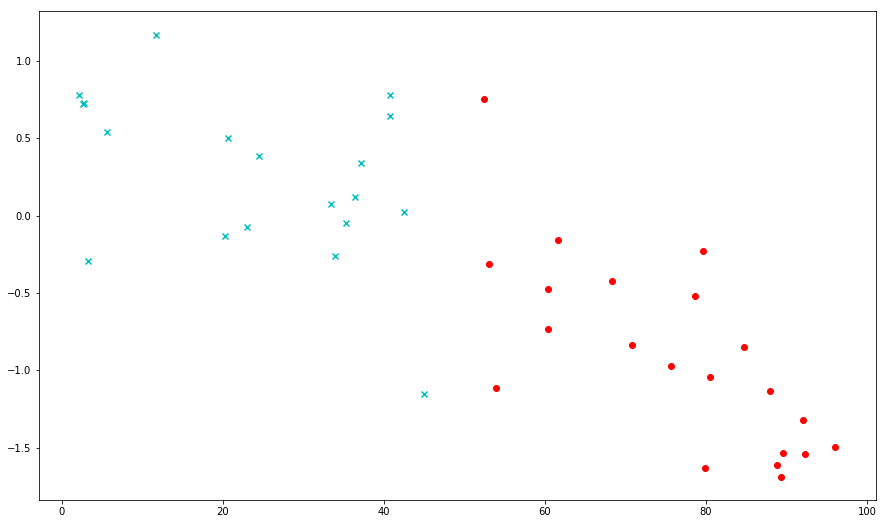

In [10]:
list_jobs = pd.read_csv(jobs_USA)

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
for index, line in list_jobs.iterrows(): 
    job = line['work']
    women_perc = float(line['women_perc'])
    
    strenght_ass = 0
    male_name = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill', 'kevin']
    female_name = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna', 'amanda']
    strenght_ass += gender_WEFAT(job,  male_name, female_name, model_w2v_AP)
    
    male_name = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son']
    female_name = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter']
    strenght_ass += gender_WEFAT(job,  male_name, female_name, model_w2v_AP)
    
    male_name = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
    female_name = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']
    strenght_ass += gender_WEFAT(job,  male_name, female_name, model_w2v_AP)

    list_jobs.at[index, 'strenght_ass'] = strenght_ass/3.
    
    if women_perc < 50.0: 
        ax.scatter(women_perc, strenght_ass/3., marker = 'x', c = 'c')
    else: 
        ax.scatter(women_perc, strenght_ass/3., marker = 'o', c = 'r')

pearson_corr = pearsonr(list_jobs['strenght_ass'], list_jobs['women_perc'])
print("Pearson’s correlation coefficient: {}".format(pearson_corr[0]))
print("with P-value ~ {}".format(pearson_corr[1]))
fig.show()
fig.savefig('images/correlation_job_streght_eng_w2v.png', bbox_inches='tight')

In [11]:
list_jobs.sort_values('women_perc')

,work,women_perc,strenght_ass
14,electrician,2.2,0.777410
18,plumber,2.7,0.720529
11,carpenter,2.8,0.728998
34,firefighters,3.3,-0.294264
23,machinist,5.6,0.540390
26,architect,11.7,1.164161
30,programmer,20.3,-0.132095
38,courier,20.7,0.499411
39,detective,23.0,-0.075647
36,farmer,24.5,0.385223


# WEAT test for English Embedding - GloVe

In [6]:
glove_6B = load_glove_embeddings(embedding_eng2_file)

In [7]:
male_name = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill', 'kevin']
female_name = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna', 'amanda']

print('    Work vs. Home')
print('##########################')
work_group = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
home_group = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
gender_WEAT_test(male_name, female_name, work_group, home_group, glove_6B)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
arts_group = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']
gender_WEAT_test(male_name, female_name, math_group, arts_group, glove_6B)

print('\n\n  Science vs. Literature')
print('##########################')
science_group = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
literature_group = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

gender_WEAT_test(male_name, female_name, science_group, literature_group, glove_6B)

    Work vs. Home
##########################
WEAT statistic test: 1.4589599698267393

Effective size: 1.7640577257423506

Tested 24310 and 0 larger than WEAT statistic test.
p_value: 0.0


   Math vs. Arts
##########################
WEAT statistic test: 0.5927864807922845

Effective size: 1.499105245089018

Tested 24310 and 0 larger than WEAT statistic test.
p_value: 0.0


  Science vs. Literature
##########################
WEAT statistic test: 0.6364381194006552

Effective size: 1.6305200808480567

Tested 24310 and 0 larger than WEAT statistic test.
p_value: 0.0


In [9]:
male_name = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son']
female_name = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter']

print('    Work vs. Home')
print('##########################')
work_group = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
home_group = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
gender_WEAT_test(male_name, female_name, work_group, home_group, glove_6B)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
arts_group = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']
gender_WEAT_test(male_name, female_name, math_group, arts_group, glove_6B)

print('\n\n  Science vs. Literature')
print('##########################')
science_group = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
literature_group = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

gender_WEAT_test(male_name, female_name, science_group, literature_group, glove_6B)

    Work vs. Home
##########################
WEAT statistic test: 0.705246042457064

Effective size: 0.7838082557977956

Tested 12870 and 849 larger than WEAT statistic test.
p_value: 0.06596736596736597


   Math vs. Arts
##########################
WEAT statistic test: 0.24277321034310817

Effective size: 0.8316224084013023

Tested 12870 and 697 larger than WEAT statistic test.
p_value: 0.05415695415695416


  Science vs. Literature
##########################
WEAT statistic test: 0.31856575553663197

Effective size: 1.2275375921031162

Tested 12870 and 58 larger than WEAT statistic test.
p_value: 0.004506604506604507


Pearson’s correlation coefficient: -0.7609408275615455
with P-value ~ 1.2050743788641636e-08


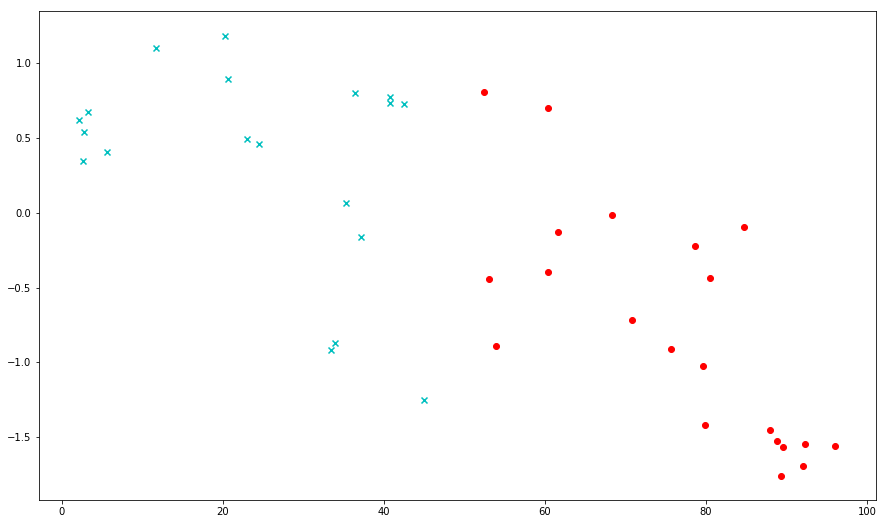

In [12]:
list_jobs = pd.read_csv(jobs_USA)

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
for index, line in list_jobs.iterrows(): 
    job = line['work']
    women_perc = float(line['women_perc'])
    
    strenght_ass = 0
    male_name = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill', 'kevin']
    female_name = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna', 'amanda']
    strenght_ass += gender_WEFAT(job,  male_name, female_name, glove_6B)
    
    male_name = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son']
    female_name = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter']
    strenght_ass += gender_WEFAT(job,  male_name, female_name, glove_6B)
    
    male_name = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
    female_name = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']
    strenght_ass += gender_WEFAT(job,  male_name, female_name, glove_6B)

    list_jobs.at[index, 'strenght_ass'] = strenght_ass/3.
    
    if women_perc < 50.0: 
        ax.scatter(women_perc, strenght_ass/3., marker = 'x', c = 'c')
    else: 
        ax.scatter(women_perc, strenght_ass/3., marker = 'o', c = 'r')

pearson_corr = pearsonr(list_jobs['strenght_ass'], list_jobs['women_perc'])
print("Pearson’s correlation coefficient: {}".format(pearson_corr[0]))
print("with P-value ~ {}".format(pearson_corr[1]))
fig.show()
fig.savefig('images/correlation_job_streght_ass_eng_glove.png', bbox_inches='tight')

In [13]:
list_jobs.sort_values('women_perc')

,work,women_perc,strenght_ass
14,electrician,2.2,0.623569
18,plumber,2.7,0.347137
11,carpenter,2.8,0.542316
34,firefighters,3.3,0.676308
23,machinist,5.6,0.409820
26,architect,11.7,1.105233
30,programmer,20.3,1.184346
38,courier,20.7,0.896940
39,detective,23.0,0.491420
36,farmer,24.5,0.460970


# WEAT test for Italian Embedding - HateSpeech Evalita

In [31]:
embeddings_ita1 = get_embedding(embedding_ita1_file)

In [10]:
male_name = ['uomo', 'zio', 'marito', 'maschio', 'padre', 'nonno']
female_name = ['donna', 'zia', 'moglie', 'femmina', 'madre', 'nonna']

print('\n\n  Science vs. Arts')
print('##########################')
science_group = ['biologia', 'fisica', 'chimica', 'matematica', 'geologia', 'astronomia', 'ingegneria']
arts_group = ['filosofia', 'umanesimo', 'arte', 'letteratura', 'italiano', 'musica', 'storia']
gender_WEAT_test(male_name, female_name, science_group, arts_group, embeddings_ita1)


print('    Work vs. Home')
print('##########################')
work_group = ['impresa', 'professionale', 'azienda', 'salario', 'ufficio', 'business', 'carriera']
home_group = ['casa', 'genitori', 'bambini', 'famiglia', 'matrimonio', 'nozze', 'parenti']
gender_WEAT_test(male_name, female_name, work_group, home_group, embeddings_ita1)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['matematica', 'algebra', 'geometria', 'calculo', 'equazioni', 'numeri', 'addizioni']
arts_group = ['poesia', 'arte', 'danza', 'letteratura', 'novelle', 'sinfonia', 'scultura']
gender_WEAT_test(male_name, female_name, science_group, arts_group, embeddings_ita1)



  Science vs. Arts
##########################
WEAT statistic test: -0.1374725401401518

Effective size: -1.0007264226601382

Tested 924 and 880 larger than WEAT statistic test.
p_value: 0.9523809523809523
    Work vs. Home
##########################
WEAT statistic test: 0.1340926757880619

Effective size: 0.5922226168790587

Tested 924 and 158 larger than WEAT statistic test.
p_value: 0.170995670995671


   Math vs. Arts
##########################
WEAT statistic test: -0.03666922450065607

Effective size: -0.33103568889645657

Tested 924 and 647 larger than WEAT statistic test.
p_value: 0.7002164502164502


In [17]:
male_name = ['uomo', 'suo', 'ragazzo', 'fratello', 'lui', 'figlio']
female_name = ['donna', 'sua', 'ragazza', 'sorella', 'lei', 'figlia']

print('\n\n  Science vs. Arts')
print('##########################')
science_group = ['biologia', 'fisica', 'chimica', 'matematica', 'geologia', 'astronomia', 'ingegneria']
arts_group = ['filosofia', 'umanesimo', 'arte', 'letteratura', 'italiano', 'musica', 'storia']
gender_WEAT_test(male_name, female_name, science_group, arts_group, embeddings_ita1)


print('    Work vs. Home')
print('##########################')
work_group = ['impresa', 'professionale', 'azienda', 'salario', 'ufficio', 'business', 'carriera']
home_group = ['casa', 'genitori', 'bambini', 'famiglia', 'matrimonio', 'nozze', 'parenti']
gender_WEAT_test(male_name, female_name, work_group, home_group, embeddings_ita1)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['matematica', 'algebra', 'geometria', 'calculo', 'equazioni', 'numeri', 'addizioni']
arts_group = ['poesia', 'arte', 'danza', 'letteratura', 'novelle', 'sinfonia', 'scultura']
gender_WEAT_test(male_name, female_name, science_group, arts_group, embeddings_ita1)



  Science vs. Arts
##########################
WEAT statistic test: -0.18898738707814888

Effective size: -1.0197033351372011

Tested 924 and 879 larger than WEAT statistic test.
p_value: 0.9512987012987013
    Work vs. Home
##########################
WEAT statistic test: -0.049203761986323646

Effective size: -0.27049211613675467

Tested 924 and 613 larger than WEAT statistic test.
p_value: 0.6634199134199135


   Math vs. Arts
##########################
WEAT statistic test: -0.0481990831238881

Effective size: -0.40384797956825064

Tested 924 and 685 larger than WEAT statistic test.
p_value: 0.7413419913419913


In [21]:
male_name = ['marco', 'francesco', 'alberto', 'mario', 'dario', 'umberto', 'luigi']
female_name = ['maria', 'francesca', 'caterina', 'teresa', 'alice', 'elena', 'alessia']

print('\n\n  Science vs. Arts')
print('##########################')
science_group = ['biologia', 'fisica', 'chimica', 'matematica', 'geologia', 'astronomia', 'ingegneria']
arts_group = ['filosofia', 'umanesimo', 'arte', 'letteratura', 'italiano', 'musica', 'storia']
gender_WEAT_test(male_name, female_name, science_group, arts_group, embeddings_ita1)


print('    Work vs. Home')
print('##########################')
work_group = ['impresa', 'professionale', 'azienda', 'salario', 'ufficio', 'business', 'carriera']
home_group = ['casa', 'genitori', 'bambini', 'famiglia', 'matrimonio', 'nozze', 'parenti']
gender_WEAT_test(male_name, female_name, work_group, home_group, embeddings_ita1)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['matematica', 'algebra', 'geometria', 'calculo', 'equazioni', 'numeri', 'addizioni']
arts_group = ['poesia', 'arte', 'danza', 'letteratura', 'novelle', 'sinfonia', 'scultura']
gender_WEAT_test(male_name, female_name, science_group, arts_group, embeddings_ita1)



  Science vs. Arts
##########################
WEAT statistic test: -0.27661976510924957

Effective size: -1.708649502159708

Tested 3432 and 3431 larger than WEAT statistic test.
p_value: 0.9997086247086248
    Work vs. Home
##########################
WEAT statistic test: 0.20204144556607523

Effective size: 1.4075002556972604

Tested 3432 and 5 larger than WEAT statistic test.
p_value: 0.001456876456876457


   Math vs. Arts
##########################
WEAT statistic test: -0.29981062029089245

Effective size: -1.6019649971724057

Tested 3432 and 3429 larger than WEAT statistic test.
p_value: 0.9991258741258742


# WEAT test for Italian Embedding - Evalita Generic

In [32]:
embeddings_ita2 = get_embedding_sqlite(embedding_ita2_file)

In [23]:
male_name = ['uomo', 'zio', 'marito', 'maschio', 'padre', 'nonno']
female_name = ['donna', 'zia', 'moglie', 'femmina', 'madre', 'nonna']

print('\n\n  Science vs. Arts')
print('##########################')
science_group = ['biologia', 'fisica', 'chimica', 'matematica', 'geologia', 'astronomia', 'ingegneria']
arts_group = ['filosofia', 'umanesimo', 'arte', 'letteratura', 'italiano', 'musica', 'storia']
gender_WEAT_test(male_name, female_name, science_group, arts_group, embeddings_ita2)


print('    Work vs. Home')
print('##########################')
work_group = ['impresa', 'professionale', 'azienda', 'salario', 'ufficio', 'business', 'carriera']
home_group = ['casa', 'genitori', 'bambini', 'famiglia', 'matrimonio', 'nozze', 'parenti']
gender_WEAT_test(male_name, female_name, work_group, home_group, embeddings_ita2)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['matematica', 'algebra', 'geometria', 'calculo', 'equazioni', 'numeri', 'addizioni']
arts_group = ['poesia', 'arte', 'danza', 'letteratura', 'novelle', 'sinfonia', 'scultura']
gender_WEAT_test(male_name, female_name, science_group, arts_group, embeddings_ita2)



  Science vs. Arts
##########################
WEAT statistic test: -0.004569005266619977

Effective size: -0.02214137826363801

Tested 924 and 471 larger than WEAT statistic test.
p_value: 0.5097402597402597
    Work vs. Home
##########################
WEAT statistic test: 0.5375979943212963

Effective size: 0.9722732513037785

Tested 924 and 44 larger than WEAT statistic test.
p_value: 0.047619047619047616


   Math vs. Arts
##########################
WEAT statistic test: 0.5425677891979616

Effective size: 1.6657690112073194

Tested 924 and 1 larger than WEAT statistic test.
p_value: 0.0010822510822510823


In [24]:
male_name = ['uomo', 'suo', 'ragazzo', 'fratello', 'lui', 'figlio']
female_name = ['donna', 'sua', 'ragazza', 'sorella', 'lei', 'figlia']

print('\n\n  Science vs. Arts')
print('##########################')
science_group = ['biologia', 'fisica', 'chimica', 'matematica', 'geologia', 'astronomia', 'ingegneria']
arts_group = ['filosofia', 'umanesimo', 'arte', 'letteratura', 'italiano', 'musica', 'storia']
gender_WEAT_test(male_name, female_name, science_group, arts_group, embeddings_ita2)


print('    Work vs. Home')
print('##########################')
work_group = ['impresa', 'professionale', 'azienda', 'salario', 'ufficio', 'business', 'carriera']
home_group = ['casa', 'genitori', 'bambini', 'famiglia', 'matrimonio', 'nozze', 'parenti']
gender_WEAT_test(male_name, female_name, work_group, home_group, embeddings_ita2)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['matematica', 'algebra', 'geometria', 'calculo', 'equazioni', 'numeri', 'addizioni']
arts_group = ['poesia', 'arte', 'danza', 'letteratura', 'novelle', 'sinfonia', 'scultura']
gender_WEAT_test(male_name, female_name, science_group, arts_group, embeddings_ita2)



  Science vs. Arts
##########################
WEAT statistic test: -0.10461618363914013

Effective size: -0.461763835729983

Tested 924 and 705 larger than WEAT statistic test.
p_value: 0.762987012987013
    Work vs. Home
##########################
WEAT statistic test: 0.18052485320234357

Effective size: 0.27292180198493277

Tested 924 and 315 larger than WEAT statistic test.
p_value: 0.3409090909090909


   Math vs. Arts
##########################
WEAT statistic test: 0.4142925729210778

Effective size: 0.9771818378072175

Tested 924 and 37 larger than WEAT statistic test.
p_value: 0.04004329004329004


In [25]:
male_name = ['marco', 'francesco', 'alberto', 'mario', 'dario', 'umberto', 'luigi']
female_name = ['maria', 'francesca', 'caterina', 'teresa', 'alice', 'elena', 'alessia']

print('\n\n  Science vs. Arts')
print('##########################')
science_group = ['biologia', 'fisica', 'chimica', 'matematica', 'geologia', 'astronomia', 'ingegneria']
arts_group = ['filosofia', 'umanesimo', 'arte', 'letteratura', 'italiano', 'musica', 'storia']
gender_WEAT_test(male_name, female_name, science_group, arts_group, embeddings_ita2)


print('    Work vs. Home')
print('##########################')
work_group = ['impresa', 'professionale', 'azienda', 'salario', 'ufficio', 'business', 'carriera']
home_group = ['casa', 'genitori', 'bambini', 'famiglia', 'matrimonio', 'nozze', 'parenti']
gender_WEAT_test(male_name, female_name, work_group, home_group, embeddings_ita2)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['matematica', 'algebra', 'geometria', 'calculo', 'equazioni', 'numeri', 'addizioni']
arts_group = ['poesia', 'arte', 'danza', 'letteratura', 'novelle', 'sinfonia', 'scultura']
gender_WEAT_test(male_name, female_name, science_group, arts_group, embeddings_ita2)



  Science vs. Arts
##########################
WEAT statistic test: -0.2619979234636319

Effective size: -1.3464772662875675

Tested 3432 and 3418 larger than WEAT statistic test.
p_value: 0.995920745920746
    Work vs. Home
##########################
WEAT statistic test: 0.3732525664312392

Effective size: 0.7460229633253771

Tested 3432 and 321 larger than WEAT statistic test.
p_value: 0.09353146853146853


   Math vs. Arts
##########################
WEAT statistic test: 0.03204605476207548

Effective size: 0.1463816712751977

Tested 3432 and 1378 larger than WEAT statistic test.
p_value: 0.4015151515151515


Pearson’s correlation coefficient: -0.6132496372160893
with P-value ~ 3.313688403223911e-05


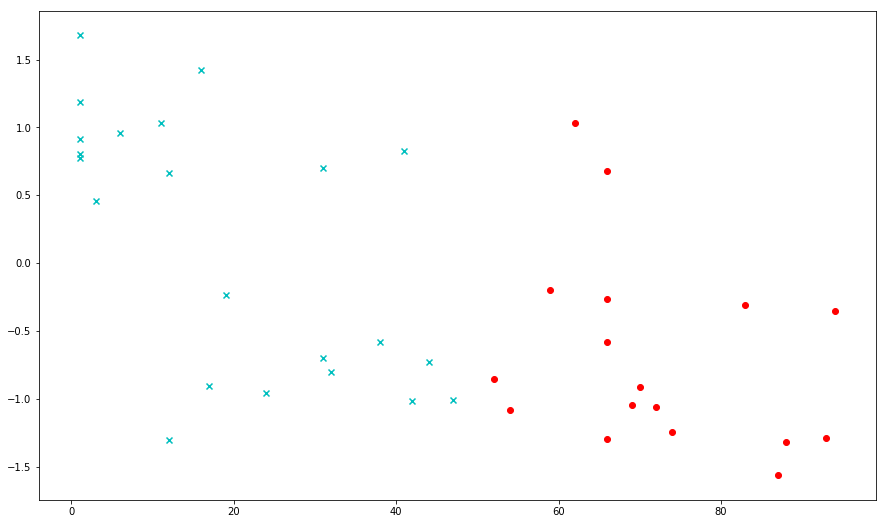

In [31]:
list_jobs = pd.read_csv(jobs_ITA)

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
for index, line in list_jobs.iterrows(): 
    job_m = line['work_men']
    job_f = line['work_women']
    women_perc = float(line['women_perc'])
    
    strenght_ass = 0
    male_name = ['uomo', 'zio', 'marito', 'maschio', 'padre', 'nonno']
    female_name = ['donna', 'zia', 'moglie', 'femmina', 'madre', 'nonna']
    strenght_ass += gender_ita_WEFAT(job_m, job_f, male_name, female_name, embeddings_ita2)
    
    male_name = ['uomo', 'suo', 'ragazzo', 'fratello', 'lui', 'figlio']
    female_name = ['donna', 'sua', 'ragazza', 'sorella', 'lei', 'figla']
    strenght_ass += gender_ita_WEFAT(job_m, job_f, male_name, female_name, embeddings_ita2)
    
    male_name = ['marco', 'francesco', 'alberto', 'mario', 'dario', 'umberto', 'luigi']
    female_name = ['maria', 'francesca', 'caterina', 'teresa', 'alice', 'elena', 'alessia']
    strenght_ass += gender_ita_WEFAT(job_m, job_f, male_name, female_name, embeddings_ita2)
        
    list_jobs.at[index, 'strenght_ass'] = strenght_ass/3.
    
    if women_perc < 50.0: 
        ax.scatter(women_perc, strenght_ass/3., marker = 'x', c = 'c')
    else: 
        ax.scatter(women_perc, strenght_ass/3., marker = 'o', c = 'r')

pearson_corr = pearsonr(list_jobs['strenght_ass'], list_jobs['women_perc'])
print("Pearson’s correlation coefficient: {}".format(pearson_corr[0]))
print("with P-value ~ {}".format(pearson_corr[1]))
fig.show()
fig.savefig('images/correlation_job_streght_ass_ita_evalita.png', bbox_inches='tight')

In [32]:
list_jobs.sort_values('women_perc')

,work_men,work_women,women_perc,strenght_ass
27,falegname,falegname,1,0.802727
7,carpentiere,carpentiere,1,1.184161
8,muratore,muratrice,1,0.773084
10,elettricista,elettricista,1,0.915005
22,idraulico,idraulica,1,1.680237
9,pescatore,pescatrice,3,0.455820
30,atleta,atleta,6,0.957015
16,geometra,geometra,11,1.035866
31,allenatore,allenatrice,12,0.661891
37,geologo,geologa,12,-1.301117


# WEAT test for Italian Embedding - word2vec 

In [33]:
model_w2v_ita = get_embedding2(embedding_ita3_file)

In [15]:
male_name = ['uomo', 'zio', 'marito', 'maschio', 'padre', 'nonno']
female_name = ['donna', 'zia', 'moglie', 'femmina', 'madre', 'nonna']

print('\n\n  Science vs. Arts')
print('##########################')
science_group = ['biologia', 'fisica', 'chimica', 'matematica', 'geologia', 'astronomia', 'ingegneria']
arts_group = ['filosofia', 'umanesimo', 'arte', 'letteratura', 'italiano', 'musica', 'storia']
gender_WEAT_test(male_name, female_name, science_group, arts_group, model_w2v_ita)


print('    Work vs. Home')
print('##########################')
work_group = ['impresa', 'professionale', 'azienda', 'salario', 'ufficio', 'business', 'carriera']
home_group = ['casa', 'genitori', 'bambini', 'famiglia', 'matrimonio', 'nozze', 'parenti']
gender_WEAT_test(male_name, female_name, work_group, home_group, model_w2v_ita)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['matematica', 'algebra', 'geometria', 'calculo', 'equazioni', 'numeri', 'addizioni']
arts_group = ['poesia', 'arte', 'danza', 'letteratura', 'novelle', 'sinfonia', 'scultura']
gender_WEAT_test(male_name, female_name, science_group, arts_group, model_w2v_ita)



  Science vs. Arts
##########################
WEAT statistic test: 0.0658194667526654

Effective size: 0.30211873609566514

Tested 924 and 266 larger than WEAT statistic test.
p_value: 0.2878787878787879
    Work vs. Home
##########################
WEAT statistic test: 0.2517017104795999

Effective size: 0.6295080194184159

Tested 924 and 148 larger than WEAT statistic test.
p_value: 0.16017316017316016


   Math vs. Arts
##########################
WEAT statistic test: 0.2883158954126494

Effective size: 1.2244764973852258

Tested 924 and 17 larger than WEAT statistic test.
p_value: 0.0183982683982684


In [17]:
male_name = ['uomo', 'suo', 'ragazzo', 'fratello', 'lui', 'figlio']
female_name = ['donna', 'sua', 'ragazza', 'sorella', 'lei', 'figlia']

print('\n\n  Science vs. Arts')
print('##########################')
science_group = ['biologia', 'fisica', 'chimica', 'matematica', 'geologia', 'astronomia', 'ingegneria']
arts_group = ['filosofia', 'umanesimo', 'arte', 'letteratura', 'italiano', 'musica', 'storia']
gender_WEAT_test(male_name, female_name, science_group, arts_group, model_w2v_ita)


print('    Work vs. Home')
print('##########################')
work_group = ['impresa', 'professionale', 'azienda', 'salario', 'ufficio', 'business', 'carriera']
home_group = ['casa', 'genitori', 'bambini', 'famiglia', 'matrimonio', 'nozze', 'parenti']
gender_WEAT_test(male_name, female_name, work_group, home_group, model_w2v_ita)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['matematica', 'algebra', 'geometria', 'calculo', 'equazioni', 'numeri', 'addizioni']
arts_group = ['poesia', 'arte', 'danza', 'letteratura', 'novelle', 'sinfonia', 'scultura']
gender_WEAT_test(male_name, female_name, science_group, arts_group, model_w2v_ita)



  Science vs. Arts
##########################
WEAT statistic test: 0.05974010058811735

Effective size: 0.7993085939754989

Tested 924 and 91 larger than WEAT statistic test.
p_value: 0.09848484848484848
    Work vs. Home
##########################
WEAT statistic test: 0.29441540581839415

Effective size: 0.5824636596534943

Tested 924 and 162 larger than WEAT statistic test.
p_value: 0.17532467532467533


   Math vs. Arts
##########################
WEAT statistic test: 0.2860036939382553

Effective size: 1.480595000263384

Tested 924 and 4 larger than WEAT statistic test.
p_value: 0.004329004329004329


In [19]:
male_name = ['marco', 'francesco', 'alberto', 'mario', 'dario', 'umberto', 'luigi']
female_name = ['maria', 'francesca', 'caterina', 'teresa', 'alice', 'elena', 'alessia']

print('\n\n  Science vs. Arts')
print('##########################')
science_group = ['biologia', 'fisica', 'chimica', 'matematica', 'geologia', 'astronomia', 'ingegneria']
arts_group = ['filosofia', 'umanesimo', 'arte', 'letteratura', 'italiano', 'musica', 'storia']
gender_WEAT_test(male_name, female_name, science_group, arts_group, model_w2v_ita)


print('    Work vs. Home')
print('##########################')
work_group = ['impresa', 'professionale', 'azienda', 'salario', 'ufficio', 'business', 'carriera']
home_group = ['casa', 'genitori', 'bambini', 'famiglia', 'matrimonio', 'nozze', 'parenti']
gender_WEAT_test(male_name, female_name, work_group, home_group, model_w2v_ita)

print('\n\n   Math vs. Arts')
print('##########################')
math_group = ['matematica', 'algebra', 'geometria', 'calculo', 'equazioni', 'numeri', 'addizioni']
arts_group = ['poesia', 'arte', 'danza', 'letteratura', 'novelle', 'sinfonia', 'scultura']
gender_WEAT_test(male_name, female_name, science_group, arts_group, model_w2v_ita)



  Science vs. Arts
##########################
WEAT statistic test: -0.21566597478730365

Effective size: -1.278381610128847

Tested 3432 and 3410 larger than WEAT statistic test.
p_value: 0.9935897435897436
    Work vs. Home
##########################
WEAT statistic test: 0.8595242904765265

Effective size: 1.8503623533015163

Tested 3432 and 1 larger than WEAT statistic test.
p_value: 0.0002913752913752914


   Math vs. Arts
##########################
WEAT statistic test: 0.0786162370017596

Effective size: 0.4665988808231449

Tested 3432 and 724 larger than WEAT statistic test.
p_value: 0.21095571095571095


Pearson’s correlation coefficient: -0.36606554880807857
with P-value ~ 0.025864276540667575


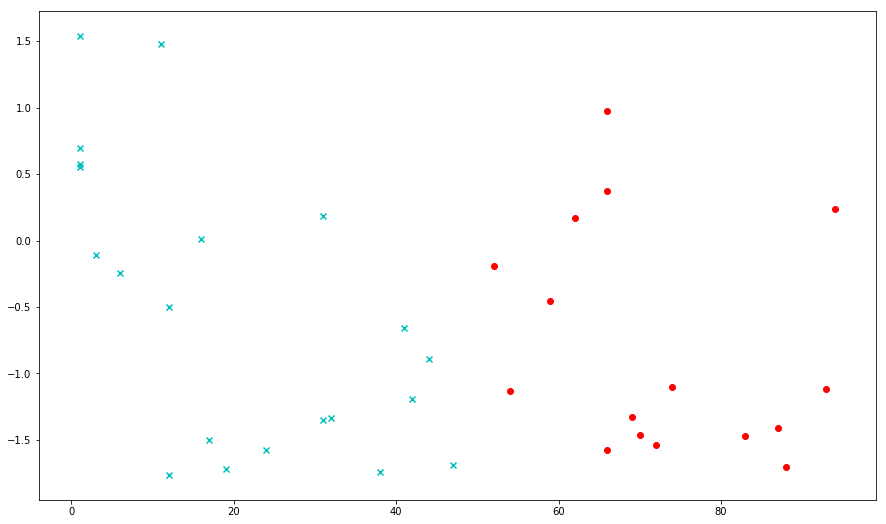

In [29]:
list_jobs = pd.read_csv(jobs_ITA)
vocab = [word for word in model_w2v_ita.vocab]

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
for index, line in list_jobs.iterrows(): 
    job_m = line['work_men']
    job_f = line['work_women']
    women_perc = float(line['women_perc'])
    
    if job_m not in vocab or job_f not in vocab: 
        list_jobs = list_jobs.drop(index=index, axis=0)
        continue
        
    strenght_ass = 0
    male_name = ['uomo', 'zio', 'marito', 'maschio', 'padre', 'nonno']
    female_name = ['donna', 'zia', 'moglie', 'femmina', 'madre', 'nonna']
    strenght_ass += gender_ita_WEFAT(job_m, job_f, male_name, female_name, model_w2v_ita)
    
    male_name = ['uomo', 'suo', 'ragazzo', 'fratello', 'lui', 'figlio']
    female_name = ['donna', 'sua', 'ragazza', 'sorella', 'lei', 'figlia']
    strenght_ass += gender_ita_WEFAT(job_m, job_f, male_name, female_name, model_w2v_ita)
    
    male_name = ['marco', 'francesco', 'alberto', 'mario', 'dario', 'umberto', 'luigi']
    female_name = ['maria', 'francesca', 'caterina', 'teresa', 'alice', 'elena', 'alessia']
    strenght_ass += gender_ita_WEFAT(job_m, job_f, male_name, female_name, model_w2v_ita)
        
    list_jobs.at[index, 'strenght_ass'] = strenght_ass/3.
    
    if women_perc < 50.0: 
        ax.scatter(women_perc, strenght_ass/3., marker = 'x', c = 'c')
    else: 
        ax.scatter(women_perc, strenght_ass/3., marker = 'o', c = 'r')

pearson_corr = pearsonr(list_jobs['strenght_ass'], list_jobs['women_perc'])
print("Pearson’s correlation coefficient: {}".format(pearson_corr[0]))
print("with P-value ~ {}".format(pearson_corr[1]))
fig.show()
fig.savefig('images/correlation_job_streght_ass_ita_v2w.png', bbox_inches='tight')

In [30]:
list_jobs.sort_values('women_perc')

,work_men,work_women,women_perc,strenght_ass
27,falegname,falegname,1,0.554784
7,carpentiere,carpentiere,1,0.693647
10,elettricista,elettricista,1,0.572385
22,idraulico,idraulica,1,1.541504
9,pescatore,pescatrice,3,-0.106822
30,atleta,atleta,6,-0.244195
16,geometra,geometra,11,1.475666
37,geologo,geologa,12,-1.761079
31,allenatore,allenatrice,12,-0.498341
29,banchiere,banchiere,16,0.012440
